# Processing the Qualtrics responses

This notebook shows how we processed the responses from Qualtrics.

1. First we define some general functions.
2. Then we perform some preliminary analyses. (Each analysis aims to be self-contained so that it can be run without looking at the other analyses.)
3. Then we export the data in long format for in-depth analysis using R.

In [1]:
# Built-in:
import csv
import json
import random
from datetime import datetime
from collections import defaultdict, Counter
from statistics import mean, stdev, median
from math import sqrt
from itertools import combinations

# Installed:
from scipy.stats import spearmanr, pearsonr, ttest_ind
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

def load_definitions():
    """
    Load all source data that was used to prompt our participants
    """
    with open("../Setup/Resources/definitions.json") as f:
        definitions = json.load(f)
        definition_index = {entry['id']: entry for entry in definitions}

    with open("../Setup/Resources/terms.json") as f:
        terms = json.load(f)
        term_index = {entry['id']: entry for entry in terms}

    for entry in definition_index.values():
        term_id = entry['term_id']
        entry['category'] = term_index[term_id]['category']
        entry['term_text'] = term_index[term_id]['term_text']

    return definition_index


def duration(entry):
    """
    Get duration from entry.
    """
    start = datetime.strptime(entry['StartDate'], "%Y-%m-%d %H:%M:%S")
    end = datetime.strptime(entry['EndDate'], "%Y-%m-%d %H:%M:%S")
    difference = end - start
    return difference.seconds


def compute_duration_dict():
    """
    Compute how long it took participants to provide responses.
    """
    with open("./Reprohum Round 2_February 11, 2024_14.08.csv") as f:
        reader = csv.DictReader(f)
        entries  = list(reader)
        metadata = entries[:2]
        entries  = entries[2:]
    durations = dict()
    for entry in entries:
        participant = entry['participant_id']
        chosen      = entry['list_choice']
        durations[(participant,chosen)] = duration(entry)
    return durations


def load_responses():
    """
    Load the responses from Qualtrics.
    """
    with open("./Reprohum Round 2_February 11, 2024_14.08.csv") as f:
        reader = csv.DictReader(f)
        entries  = list(reader)
        metadata = entries[:2]
        entries  = entries[2:]

    identifiers = [key for key in entries[0].keys() if len(key) == 32]

    response_index = defaultdict(dict)
    for entry in entries:
        participant = entry['participant_id']
        chosen      = entry['list_choice']
        answer_dict = {ident: entry[ident] for ident in identifiers if entry[ident] != ''}
        if answer_dict == {}:
            continue
        if chosen in response_index[participant]:
            response_index[participant][chosen].append(answer_dict)
        else:
            response_index[participant][chosen] = [answer_dict]
    
    # Check that the answers are actually from a single complete session.
    # If not, delete them.
    for participant, responses in response_index.items():
        for i, some_list in responses.items():
            for answers in some_list:
                if len(answers) != 30:
                    some_list.remove(answers)
    
    return response_index, identifiers

## General overview

Ensure that the data looks like what we want it to look like. First get a quick overview:

In [2]:
response_index, identifiers = load_responses()
print("Progress:")
print("---------")
for participant, responses in sorted(response_index.items()):
    print(participant, '\t', len(responses))
print("---------")

Progress:
---------
001 	 10
002 	 10
003 	 4
004 	 4
005 	 4
006 	 4
007 	 4
008 	 4
009 	 10
010 	 10
---------


Then get a more detailed list of items:

In [3]:
response_index, identifiers = load_responses()
for participant, responses in sorted(response_index.items()):
    print("--------------------------------------")
    print(f"Participant {participant} provided {len(responses)} responses:")
    for i, some_list in responses.items():
        for j, answer_set in enumerate(some_list):
            print("list", str(i).zfill(2), "has", len(answer_set), "ratings", "(duplicate)" if j >0 else "")
print("--------------------------------------")

--------------------------------------
Participant 001 provided 10 responses:
list 01 has 30 ratings 
list 02 has 30 ratings 
list 03 has 30 ratings 
list 04 has 30 ratings 
list 05 has 30 ratings 
list 06 has 30 ratings 
list 07 has 30 ratings 
list 08 has 30 ratings 
list 09 has 30 ratings 
list 10 has 30 ratings 
--------------------------------------
Participant 002 provided 10 responses:
list 01 has 30 ratings 
list 02 has 30 ratings 
list 03 has 30 ratings 
list 03 has 30 ratings (duplicate)
list 04 has 30 ratings 
list 04 has 30 ratings (duplicate)
list 05 has 30 ratings 
list 06 has 30 ratings 
list 07 has 30 ratings 
list 07 has 30 ratings (duplicate)
list 08 has 30 ratings 
list 09 has 30 ratings 
list 10 has 30 ratings 
--------------------------------------
Participant 003 provided 4 responses:
list 01 has 30 ratings 
list 02 has 30 ratings 
list 03 has 30 ratings 
list 04 has 30 ratings 
--------------------------------------
Participant 004 provided 4 responses:
list 01 h

## Compute self-correlation for accidental duplicate entries.

One participant accidentally filled in the same lists multiple times. We use this happy little accident to assess the intra-annotator agreement for this individual.

In [4]:
dups1 = []
dups2 = []
response_index, identifiers = load_responses()
for participant, list_index in response_index.items():
    for number, responses in list_index.items():
        if len(responses) > 1:
            answers = [[int(response[key]) for key in responses[0].keys()] for response in responses]
            dups1.extend(answers[0])
            dups2.extend(answers[1])
            print(f"Ppt {participant}, list {number}, Spearman's R: {spearmanr(*answers)[0]:.2f}")
            print(f"Ppt {participant}, list {number}, Pearson's R:  {pearsonr(*answers)[0]:.2f}")

print("Overall:")
print(f"Spearman's R: {spearmanr(dups1,dups2)[0]:.2f}")

Ppt 002, list 3, Spearman's R: 0.86
Ppt 002, list 3, Pearson's R:  0.87
Ppt 002, list 4, Spearman's R: 0.74
Ppt 002, list 4, Pearson's R:  0.75
Ppt 002, list 7, Spearman's R: 0.94
Ppt 002, list 7, Pearson's R:  0.96
Overall:
Spearman's R: 0.85


## Compute correlation between raters.

We should be able to obtain the same values in R.

In [5]:
response_index, identifiers = load_responses()
participants = set(response_index.keys())

correlations = defaultdict(dict)

for a,b in combinations(participants, 2):
    keys_a = set(response_index[a].keys())
    keys_b = set(response_index[b].keys())
    overlap = keys_a & keys_b
    list_a = []
    list_b = []
    diffs  = []
    for key in overlap:
        for ident, rating in response_index[a][key][0].items():
            rating_a = int(rating)
            rating_b = int(response_index[b][key][0][ident])
            list_a.append(rating_a)
            list_b.append(rating_b)
            diff = abs(rating_a - rating_b)
            diffs.append(diff)
    spearman = spearmanr(list_a, list_b)[0]
    pearson = pearsonr(list_a, list_b)[0]
    a = 'p' + str(a)[1:]
    b = 'p' + str(b)[1:]
    a = int(a[1:])
    b = int(b[1:])
    correlations[a]['key'] = a
    correlations[b]['key'] = b
    correlations[a][b] = spearman
    correlations[b][a] = spearman
    correlations[a][a] = 1
    correlations[b][b] = 1
    print(a, b, f"Spearman: {spearman:.2f} over {len(list_a)} items")
    print(a, b, f"Pearson:  {pearson:.2f} over {len(list_a)} items")
    print(a, b, f"Average difference: {sum(diffs)/len(diffs):.2f}. Min: {min(diffs)}, Max: {max(diffs)}.")
    print("---")

1 8 Spearman: 0.49 over 120 items
1 8 Pearson:  0.50 over 120 items
1 8 Average difference: 0.88. Min: 0, Max: 3.
---
1 4 Spearman: 0.63 over 120 items
1 4 Pearson:  0.63 over 120 items
1 4 Average difference: 0.63. Min: 0, Max: 3.
---
1 5 Spearman: 0.61 over 120 items
1 5 Pearson:  0.58 over 120 items
1 5 Average difference: 0.71. Min: 0, Max: 3.
---
1 10 Spearman: 0.70 over 300 items
1 10 Pearson:  0.70 over 300 items
1 10 Average difference: 0.66. Min: 0, Max: 3.
---
1 7 Spearman: 0.64 over 120 items
1 7 Pearson:  0.65 over 120 items
1 7 Average difference: 0.68. Min: 0, Max: 3.
---
1 6 Spearman: 0.60 over 120 items
1 6 Pearson:  0.59 over 120 items
1 6 Average difference: 0.70. Min: 0, Max: 3.
---
1 9 Spearman: 0.64 over 300 items
1 9 Pearson:  0.61 over 300 items
1 9 Average difference: 0.91. Min: 0, Max: 3.
---
1 2 Spearman: 0.65 over 300 items
1 2 Pearson:  0.67 over 300 items
1 2 Average difference: 0.77. Min: 0, Max: 3.
---
1 3 Spearman: 0.46 over 120 items
1 3 Pearson:  0.46 

## Show correlations as heatmap table

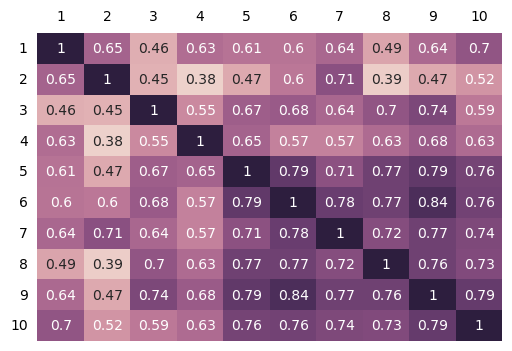

In [6]:
df = pd.DataFrame(sorted(correlations.values(), key=lambda x:x['key']), columns=['key'] + sorted(correlations.keys()))
df = df.set_index('key')
plt.figure(figsize=(6,4))
sns.heatmap(df, vmin=0.38, vmax=0.9, 
            annot=True,
            cbar=False,
            cmap=sns.cubehelix_palette(as_cmap=True))#,
            #mask=np.identity(10))
plt.yticks(rotation=0)
plt.ylabel('')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, left=False, top = False, labeltop=True)
plt.savefig("Heatmap.pdf")

See average correlation:

In [7]:
print("Average correlation with others:")
for key, values in sorted(correlations.items()):
    scores = [values[i] for i in range(1,11) if not i==key]
    print(key, sum(scores)/10)

Average correlation with others:
1 0.5411837430199359
2 0.46519595844494904
3 0.5479631065491681
4 0.5282130100291871
5 0.621644569428365
6 0.6378973140363432
7 0.6274858960017038
8 0.5950586307097139
9 0.6473837923140586
10 0.6211955300254652


## Streamline the data.

In [8]:
definition_index = load_definitions()
response_index, identifiers = load_responses()
durations = compute_duration_dict()
rows = []
for participant, responses in response_index.items():
    for list_number, scores in responses.items():
        for item, score in scores[0].items():
            entry = dict()
            entry['participant'] = participant
            entry['list_number'] = list_number
            entry['duration'] = durations[(participant,list_number)]
            # 30 items per list, so position on the list is index (zero-indexed) modulo 30, plus one.
            # We can see this on list 1 where numbers start at 0 and go up to 29.
            # List 2 starts with the definition with index 30, mod 30 is 0.
            # To make the positions more human-friendly again we add one, to end up with the range 1-30 (inclusive).
            entry['position'] = (identifiers.index(item) % 30) + 1
            entry['item'] = item
            entry['category'] = definition_index[item]['category']
            entry['model_type'] = definition_index[item]['model_type']
            entry['term_id'] = definition_index[item]['term_id']
            entry['score'] = score
            rows.append(entry)            

# General overview of the results, in long format.
df = pd.DataFrame(rows)
df.to_excel("results.xlsx", index=False)

# Table for inter-annotator agreement, if necessary.
iaa = df.pivot(index="item", columns="participant", values="score").fillna('')
iaa.to_excel("iaa.xlsx")

In [9]:
df.head()

,participant,list_number,duration,position,item,category,model_type,term_id,score
0,002,1,2520,1,c98d145036c147f8a16d603c319932de,WIKI,DEXPERT-JOURNAL,107,2
1,002,1,2520,2,ba1f7cec7b874845a4925e9c62ee7c46,MEDQUAD,GEDI-NEWS,103,4
2,002,1,2520,3,14ac7eb8160748a0952434dd58d2d04d,WIKI,GEDI-NEWS,149,2
3,002,1,2520,4,4a0194a4be524557ba82bd6351960e9d,WIKI,SVM-RERANK-NEWS,132,4
4,002,1,2520,5,63c931d0e9d04676b193f04bf12eabaf,MEDQUAD,DEXPERT-JOURNAL,140,3


In [10]:
durations = defaultdict(dict)
for entry in df.to_dict('records'):
    participant = entry['participant']
    list_number = entry['list_number']
    duration = entry['duration']
    durations[participant][list_number] = duration

def create_entry(participant, values):
    return dict(ppt=participant,
                min=minutes(min(values)),
                max=minutes(max(values)),
                mean=minutes(mean(values)),
                median=minutes(median(values)),
                std=minutes(stdev(values)),
                total=minutes(sum(values)))

def minutes(seconds):
    return seconds / 60

entries = []
overall = []
for participant, d in durations.items():
    participant = int(participant)
    entry=create_entry(participant, d.values())
    overall.extend(d.values())
    entries.append(entry)

entries.sort(key=lambda d:d['ppt'])                            
entries.append(create_entry("Overall", overall))
durations = pd.DataFrame(entries)
durations.set_index('ppt')
# print(durations)
# For easy reporting:
# print(durations.to_latex(index=False,float_format="%.0f",bold_rows=True))
durations

,ppt,min,max,mean,median,std,total
0,1,21.183333,1284.150000,194.618333,48.208333,387.803501,1946.183333
1,2,3.400000,42.000000,11.283333,8.675000,11.208933,112.833333
2,3,2.916667,10.366667,4.854167,3.066667,3.675781,19.416667
3,4,4.466667,1421.300000,359.150000,5.416667,708.100509,1436.600000
4,5,6.816667,11.216667,9.358333,9.700000,2.137171,37.433333
5,6,6.000000,16.766667,9.958333,8.533333,4.697231,39.833333
6,7,4.216667,35.466667,15.508333,11.175000,13.768002,62.033333
7,8,3.550000,12.116667,6.529167,5.225000,3.884618,26.116667
8,9,4.216667,7.716667,5.548333,5.666667,1.160871,55.483333
9,10,3.400000,32.300000,7.585000,4.875000,8.720589,75.850000


## Compute the distribution of the scores

Create a data frame to get percentages.

In [11]:
scores = defaultdict(Counter)
for entry in df.to_dict('records'):
    model_type=entry['model_type']
    score = entry['score']
    scores[model_type][score] += 1

entries = []
for model_type, counts in scores.items():
    total = sum(counts.values())
    for score,count in counts.items():
        entry = dict(model_type=model_type,
                     score = score,
                     percentage= (count/total)*100)
        entries.append(entry)

percentages = pd.DataFrame(sorted(entries, key=lambda entry: [entry['model_type'],entry['score']]))


Visualise the result:

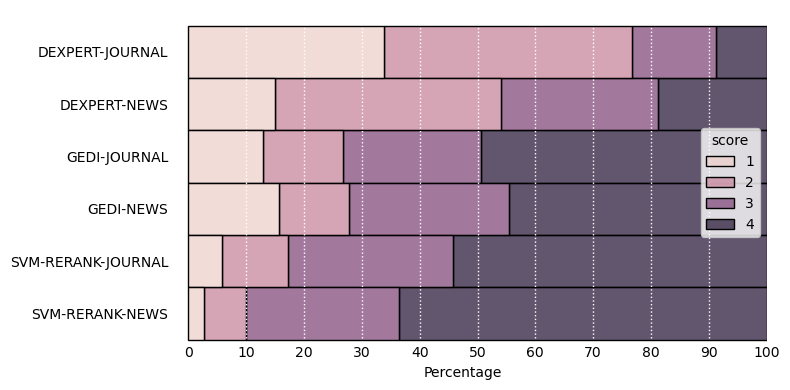

In [12]:
plt.figure(figsize=(8,4))

###################
# Plot the data:

ax = sns.histplot(percentages.sort_values(by="model_type"), 
                  y='model_type', 
                  hue='score', 
                  weights='percentage', 
                  multiple='stack',
                  palette=sns.cubehelix_palette(4))

###################
# Make it prettier:

sns.move_legend(ax, "center right")
ax.set_xlabel("Percentage")
ax.set_ylabel("")
sns.despine(left=True,bottom=True)
for i in range(10,91,10):
    plt.axvline(i, 0.05, 0.95, color="white", linewidth=1,linestyle="dotted")

ax.tick_params(axis='x', 
               bottom=False, 
               labelbottom=True, 
               which='major', 
               pad=-10)

plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=True,
    pad=-10)

plt.gca().invert_xaxis()
plt.xticks(np.arange(0,101,10), np.arange(100,-1,-10))

plt.tight_layout()
plt.savefig("ScoreDistribution.pdf")

## Run the statistics

Preliminary definitions:

In [13]:
# Code copied from: Copied from: https://stackoverflow.com/a/21532472
# Turned the code into a function; verified the result in R.

def cohensD(c0,c1):
    """
    Compute Cohen's D for two samples.
    """
    return (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))


from numpy import var
# function to calculate Cohen's d for independent samples
# source: https://machinelearningmastery.com/effect-size-measures-in-python/
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

Run the t-test so we know whether the original study reproduces:

In [14]:
df['approach'] = df['model_type'].apply(lambda model: model.split('-')[0])
participants = ['001','002']

reproduction = df[df['participant'].isin(participants)]

svm = reproduction[reproduction['approach'] == 'SVM']['score'].apply(int)
gedi = reproduction[reproduction['approach'] == 'GEDI']['score'].apply(int)
dexpert = reproduction[reproduction['approach'] == 'DEXPERT']['score'].apply(int)

print(f"SVM Mean: {mean(svm):.2f} ({stdev(svm):.2f})")
print(f"GeDi Mean: {mean(gedi):.2f} ({stdev(gedi):.2f})")
print(f"DExpert Mean: {mean(dexpert):.2f} ({stdev(dexpert):.2f})\n")

result_svm_gedi = ttest_ind(svm, gedi)
print("SVM versus GeDi:", result_svm_gedi)
print("Cohen's D, SVM versus GeDi:",
      cohensD(svm, gedi),cohend(svm, gedi))

result_svm_dexpert = ttest_ind(svm, dexpert)
print("SVM versus DExpert:", result_svm_dexpert)
print("Cohen's D, SVM versus DExpert:",
      cohensD(svm, dexpert), cohend(svm, dexpert))

SVM Mean: 3.12 (0.92)
GeDi Mean: 2.57 (1.21)
DExpert Mean: 2.27 (1.00)

SVM versus GeDi: TtestResult(statistic=5.157432121421448, pvalue=3.9556766718405247e-07, df=398.0)
Cohen's D, SVM versus GeDi: 0.5157432121421448 0.5157432121421444
SVM versus DExpert: TtestResult(statistic=8.818736584257904, pvalue=3.6671172751467334e-17, df=398.0)
Cohen's D, SVM versus DExpert: 0.8818736584257904 0.8818736584257899


Check if these results line up with those in R:

In [15]:
# !pip install rpy2 

import rpy2
import rpy2.robjects as robjects

## To aid in printing HTML in notebooks
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

from rpy2.robjects.packages import importr, data
utils = importr('utils')
base = importr('base')
dir(base)
# Run first time:
# utils.install_packages('lsr')
lsr = importr('lsr')


print("Cohen's D for SVM versus GeDi:", 
      lsr.cohensD(x=robjects.IntVector(svm),y=robjects.IntVector(gedi)))
print("Cohen's D for SVM versus DExpert:", 
      lsr.cohensD(x=robjects.IntVector(svm),y=robjects.IntVector(dexpert)))

Cohen's D for SVM versus GeDi: [1] 0.5157432

Cohen's D for SVM versus DExpert: [1] 0.8818737



In [16]:
print("SVM versus GeDi")
stats = importr('stats')
results = stats.t_test(x=robjects.IntVector(svm),
                       y=robjects.IntVector(gedi),
                       var_equal=True, 
                       detailed=True)
print(results)

print("SVM versus DExpert")
stats = importr('stats')
results = stats.t_test(x=robjects.IntVector(svm),
                       y=robjects.IntVector(dexpert),
                       var_equal=True,
                       detailed=True)
print(results)

SVM versus GeDi

	Welch Two Sample t-test

data:  c(4L, 2L, 3L, 3L, 4L, 2L, 3L, 3L, 4L, 2L, 4L, 4L, 3L, 4L, 4L, 4L, 4L, 1L, 2L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 3L, 1L, 4L, 1L, 4L, 2L, 4L, 3L, 4L, 4L, 4L, 3L, 1L, 4L, 2L, 4L, 4L, 1L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 1L, 4L, 4L, 4L, 2L, 4L, 4L, 1L, 4L, 1L, 3L, 2L, 1L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 3L, 4L, 2L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 1L, 4L, 4L, 4L, 4L, 3L, 3L, 4L, 4L, 3L, 4L, 4L, 2L, 4L, 4L, 4L, 4L, 3L, 4L, 3L, 4L, 3L, 4L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 2L, 3L, 3L, 4L, 3L, 3L, 2L, 3L,  3L, 4L, 3L, 3L, 1L, 3L, 2L, 3L, 3L, 3L, 1L, 3L, 1L, 3L, 3L, 1L, 3L, 1L, 3L, 2L, 2L, 2L, 2L, 4L, 3L, 3L, 3L, 3L, 1L, 3L, 3L, 4L, 2L, 3L, 2L, 2L, 3L, 2L, 3L, 3L, 2L, 2L, 3L, 3L, 4L, 4L, 4L, 3L, 3L, 4L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 4L, 3L, 3L, 3L, 2L, 3L, 3L, 3L, 3L, 2L, 2L, 3L, 3L, 3L, 4L, 4L, 3L, 3L) and c(4L, 2L, 2L, 3L, 3L, 1L, 3L, 2L, 2L, 4L, 4L, 4L, 4L, 2L, 4L, 4L, 4L, 1L, 4L, 4L, 1L, 4L, 4L, 4L, 4L, 1L, 1L, 2L, 4L, 1L, 1L, 4L, 4L, 4L, 1L, 3

In [17]:
# This is a local script in our repository.
# Source: https://github.com/evanmiltenburg/coeff-var
from small_sample_cv import cv

print(f'SVM: cv(3.71, 3.12)={cv([[3.71, 3.12]])["cv"]:.3f}') # SVM old, new
print(f'GeDi: cv(3.20, 2.57)={cv([[3.20, 2.57]])["cv"]:.3f}') # GeDi old, new
print(f'DExpert: cv(2.33, 2.27)={cv([[2.33, 2.27]])["cv"]:.3f}') # DExpert old, new

SVM: cv(3.71, 3.12)=17.225
GeDi: cv(3.20, 2.57)=21.772
DExpert: cv(2.33, 2.27)=2.601


## Run the statistics again
Compare the two raters from our team, to see if we obtain similar results.

In [18]:
df['approach'] = df['model_type'].apply(lambda model: model.split('-')[0])
participants = ['009','010']

reproduction = df[df['participant'].isin(participants)]

svm2 = reproduction[reproduction['approach'] == 'SVM']['score'].apply(int)
gedi2 = reproduction[reproduction['approach'] == 'GEDI']['score'].apply(int)
dexpert2 = reproduction[reproduction['approach'] == 'DEXPERT']['score'].apply(int)

print(f"SVM Mean: {mean(svm2):.2f} ({stdev(svm2):.2f})")
print(f"GeDi Mean: {mean(gedi2):.2f} ({stdev(gedi2):.2f})")
print(f"DExpert Mean: {mean(dexpert2):.2f} ({stdev(dexpert2):.2f})\n")

result_svm_gedi2 = ttest_ind(svm2, gedi2)
print("SVM versus GeDi:", result_svm_gedi2)

result_svm_dexpert2 = ttest_ind(svm2, dexpert2)
print("SVM versus DExpert:", result_svm_dexpert2)


print("Cohen's D, SVM versus GeDi:",
      cohensD(svm2, gedi2))

print("Cohen's D, SVM versus DExpert:",
      cohensD(svm2, dexpert2))

SVM Mean: 3.62 (0.64)
GeDi Mean: 3.23 (0.94)
DExpert Mean: 2.27 (0.92)

SVM versus GeDi: TtestResult(statistic=4.903211557232882, pvalue=1.3758228599445119e-06, df=398.0)
SVM versus DExpert: TtestResult(statistic=17.15524181802501, pvalue=8.788001460989319e-50, df=398.0)
Cohen's D, SVM versus GeDi: 0.4903211557232881
Cohen's D, SVM versus DExpert: 1.715524181802501


## What if we compare the two sets of raters?

In [19]:
from statsmodels.stats.weightstats import ttost_ind

"""
Documentation: https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ttost_ind.html

TOST: two one-sided t tests

null hypothesis: m1 - m2 < low or m1 - m2 > upp alternative hypothesis: low < m1 - m2 < upp

where m1, m2 are the means, expected values of the two samples.

If the pvalue is smaller than a threshold, say 0.05, then we reject the hypothesis that 
the difference between the two samples is larger than the the thresholds given by low and upp.
"""

es,label = (0.5, "medium")
low = -(es * stdev(svm))
upp = (es * stdev(svm))
print(f"Running TTOST with {label} effect size ({es}) Low: {low:.3f}, Upp: {upp:.3f}")
pval, (t1, pval1, df1), (t2, pval2, df2) = ttost_ind(svm, svm2, low, upp)
print(f"Result: a p-value of: {pval:.3f}\n")

if pval < 0.05:
    print("We reject the hypothesis that the effect size is larger than 0.5.")
else:
    print("We cannot reject the hypothesis that the effect size is larger than 0.5.")

Running TTOST with medium effect size (0.5) Low: -0.462, Upp: 0.462
Result: a p-value of: 0.684

We cannot reject the hypothesis that the effect size is larger than 0.5.


In [20]:
result_svm_svm2 = ttest_ind(svm, svm2)

print("SVM_1 versus SVM_2", result_svm_svm2)
print("Cohen's D, SVM_1 versus SVM_2:",
      cohensD(svm, svm2))

SVM_1 versus SVM_2 TtestResult(statistic=-6.29928227091104, pvalue=7.926652843592349e-10, df=398.0)
Cohen's D, SVM_1 versus SVM_2: -0.6299282270911041
